In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## STEP 1: LOAD BEIJING PM2.5 DATA

In [2]:
def load_beijing_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nFirst few rows:\n{df.head()}")
    print(f"\nDataset info:")
    print(df.info())
    return df

## STEP 2: PREPROCESSING FOR BEIJING DATA

In [3]:
def preprocess_beijing_data(df):
    print("\n" + "="*50)
    print("PREPROCESSING")
    print("="*50)

    # Create datetime from year, month, day, hour
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

    # Check missing values before handling
    print(f"\nMissing values before cleaning:")
    print(df.isnull().sum())

    # Handle missing PM2.5 values (our target)
    initial_rows = len(df)
    df = df.dropna(subset=['pm2.5']).copy()
    print(f"\nDropped {initial_rows - len(df)} rows with missing PM2.5 values")

    # Fill missing meteorological data with forward fill then backward fill
    weather_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    for col in weather_cols:
        if col in df.columns:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    # Handle categorical wind direction
    if 'cbwd' in df.columns:
        df['cbwd'] = df['cbwd'].fillna('Unknown')

    # Remove outliers (PM2.5 > 500 is very rare and likely measurement error)
    df = df[df['pm2.5'] < 500].copy()

    # Sort by datetime
    df = df.sort_values('datetime').reset_index(drop=True)

    print(f"\nAfter preprocessing: {df.shape[0]} rows")
    print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"PM2.5 range: {df['pm2.5'].min():.2f} to {df['pm2.5'].max():.2f}")
    print(f"PM2.5 mean: {df['pm2.5'].mean():.2f}, median: {df['pm2.5'].median():.2f}")

    return df

## STEP 3: EDA - SPLIT INTO FOUR FUNCTIONS 

In [4]:
def perform_eda_overview(df, save_fig=True):
    """Overview plots: histogram, pm2.5 over time sample, monthly & hourly averages"""
    print("\n--- EDA OVERVIEW ---")
    fig = plt.figure(figsize=(14, 10))
    
    # Subplot 1: Histogram PM2.5
    ax1 = plt.subplot2grid((2,2), (0,0))
    sns.histplot(df['pm2.5'], bins=50, kde=False, ax=ax1)
    ax1.set_title('PM2.5 Distribution')
    ax1.set_xlabel('PM2.5 (μg/m³)')
    ax1.grid(axis='y', alpha=0.3)
    
    # Subplot 2: PM2.5 over time (sample)
    ax2 = plt.subplot2grid((2,2), (0,1))
    sample = df.sample(min(1000, len(df))).sort_values('datetime')
    ax2.plot(sample['datetime'], sample['pm2.5'], linewidth=0.7)
    ax2.set_title('PM2.5 Over Time (sample)')
    ax2.set_xlabel('Datetime')
    ax2.set_ylabel('PM2.5')
    ax2.tick_params(axis='x', labelrotation=30)
    
    # Subplot 3: Monthly average
    ax3 = plt.subplot2grid((2,2), (1,0))
    monthly = df.groupby('month')['pm2.5'].mean()
    ax3.bar(monthly.index, monthly.values, color='tab:blue', edgecolor='black')
    ax3.set_title('Monthly Average PM2.5')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Avg PM2.5')
    ax3.set_xticks(range(1,13))
    
    # Subplot 4: Hourly average
    ax4 = plt.subplot2grid((2,2), (1,1))
    hourly = df.groupby('hour')['pm2.5'].mean()
    ax4.bar(hourly.index, hourly.values, color='tab:orange', edgecolor='black')
    ax4.set_title('Hourly Average PM2.5')
    ax4.set_xlabel('Hour')
    ax4.set_ylabel('Avg PM2.5')
    ax4.set_xticks(range(0,24,1))
    
    plt.tight_layout()
    if save_fig:
        plt.savefig('beijing_eda_overview.png', dpi=300, bbox_inches='tight')
        print("Saved: beijing_eda_overview.png")
    plt.show()

def perform_eda_temporal(df, save_fig=True):
    """Temporal trends: yearly average and monthly bars"""
    print("\n--- EDA TEMPORAL ---")
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    yearly = df.groupby('year')['pm2.5'].mean().reset_index()
    axes[0].plot(yearly['year'], yearly['pm2.5'], marker='o', linewidth=3)
    axes[0].set_title('Average PM2.5 by Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Avg PM2.5')
    axes[0].grid(alpha=0.3)
    
    monthly = df.groupby('month')['pm2.5'].mean().reset_index()
    cmap = plt.get_cmap('viridis')
    bars = axes[1].bar(monthly['month'], monthly['pm2.5'], color=cmap(np.linspace(0,1,12)))
    axes[1].set_title('Average PM2.5 by Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Avg PM2.5')
    axes[1].set_xticks(range(1,13))
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig('beijing_eda_temporal.png', dpi=300, bbox_inches='tight')
        print("Saved: beijing_eda_temporal.png")
    plt.show()

def perform_eda_weather(df, save_fig=True):
    """Weather impact: TEMP vs pm2.5 and DEWP vs pm2.5 scatter with OLS trendline"""
    print("\n--- EDA WEATHER IMPACT ---")
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    # TEMP vs PM2.5 (sample)
    sample = df.sample(min(1000, len(df)))
    axes[0].scatter(sample['TEMP'], sample['pm2.5'], alpha=0.5, s=10)
    axes[0].set_xlabel('TEMP (°C)')
    axes[0].set_ylabel('PM2.5')
    axes[0].set_title('Temperature vs PM2.5')
    # Add OLS line (np.polyfit)
    try:
        coeffs = np.polyfit(sample['TEMP'].astype(float), sample['pm2.5'].astype(float), deg=1)
        xvals = np.linspace(sample['TEMP'].min(), sample['TEMP'].max(), 100)
        yvals = coeffs[0]*xvals + coeffs[1]
        axes[0].plot(xvals, yvals, color='red', linestyle='--', lw=2, label='OLS')
        axes[0].legend()
    except Exception:
        pass
    
    # DEWP vs PM2.5 (sample)
    axes[1].scatter(sample['DEWP'], sample['pm2.5'], alpha=0.5, s=10, color='green')
    axes[1].set_xlabel('DEWP (°C)')
    axes[1].set_ylabel('PM2.5')
    axes[1].set_title('Dew Point vs PM2.5')
    try:
        coeffs2 = np.polyfit(sample['DEWP'].astype(float), sample['pm2.5'].astype(float), deg=1)
        x2 = np.linspace(sample['DEWP'].min(), sample['DEWP'].max(), 100)
        y2 = coeffs2[0]*x2 + coeffs2[1]
        axes[1].plot(x2, y2, color='red', linestyle='--', lw=2, label='OLS')
        axes[1].legend()
    except Exception:
        pass
    
    plt.tight_layout()
    if save_fig:
        plt.savefig('beijing_eda_weather.png', dpi=300, bbox_inches='tight')
        print("Saved: beijing_eda_weather.png")
    plt.show()

def perform_eda_correlation(df, save_fig=True):
    """Correlation matrix for selected columns (pm2.5, DEWP, TEMP, PRES, Iws, Is, Ir)"""
    print("\n--- EDA CORRELATIONS ---")
    corr_cols = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    corr_cols = [c for c in corr_cols if c in df.columns]
    corr_data = df[corr_cols].corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1, square=False)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    if save_fig:
        plt.savefig('beijing_eda_correlation.png', dpi=300, bbox_inches='tight')
        print("Saved: beijing_eda_correlation.png")
    plt.show()

def perform_eda(df):
    """
    Orchestrator: run all EDA subfunctions (Overview, Temporal, Weather, Correlations)
    Also keep older EDA steps (boxplots and IQR outlier detection) below for completeness.
    """
    print("\n" + "="*60)
    print("RUNNING FULL EDA SUITE (Overview, Temporal, Weather, Correlations, Extras)")
    print("="*60)
    
    # Run the four tab-equivalent EDA functions
    perform_eda_overview(df)
    perform_eda_temporal(df)
    perform_eda_weather(df)
    perform_eda_correlation(df)
    
    # Existing EDA extras you had previously: boxplots and IQR outlier detection
    print("\n--- EDA EXTRA: Boxplots & Outlier Detection ---")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(x='month', y='pm2.5', data=df, ax=axes[0], palette='viridis')
    axes[0].set_title('PM2.5 Distribution by Month (Seasonality)', fontweight='bold')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('PM2.5 (μg/m³)')

    sns.boxplot(x='hour', y='pm2.5', data=df, ax=axes[1], palette='cool')
    axes[1].set_title('PM2.5 Distribution by Hour (Daily Cycle)', fontweight='bold')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('PM2.5 (μg/m³)')
    plt.tight_layout()
    plt.savefig('beijing_eda_boxplots.png', dpi=300, bbox_inches='tight')
    print("Saved: beijing_eda_boxplots.png")
    plt.show()

    # IQR outlier detection
    Q1 = df['pm2.5'].quantile(0.25)
    Q3 = df['pm2.5'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = len(df[(df['pm2.5'] < lower_bound) | (df['pm2.5'] > upper_bound)])
    print(f"IQR method: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"Number of statistical outliers (1.5*IQR): {outliers_count}")

## STEP 4: FEATURE ENGINEERING

In [5]:
def create_beijing_features(df):
    """
    Extract features from Beijing PM2.5 dataset
    """
    print("\n" + "="*50)
    print("FEATURE ENGINEERING")
    print("="*50)

    df = df.copy()

    # Time features
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)

    # Cyclical encoding for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Rolling averages of PM2.5 (past 3, 6, 12, 24 hours)
    df['pm2.5_rolling_3h'] = df['pm2.5'].rolling(window=3, min_periods=1).mean()
    df['pm2.5_rolling_6h'] = df['pm2.5'].rolling(window=6, min_periods=1).mean()
    df['pm2.5_rolling_12h'] = df['pm2.5'].rolling(window=12, min_periods=1).mean()
    df['pm2.5_rolling_24h'] = df['pm2.5'].rolling(window=24, min_periods=1).mean()

    # Lag features (PM2.5 from 1, 3, 6, 12, 24 hours ago)
    df['pm2.5_lag_1h'] = df['pm2.5'].shift(1)
    df['pm2.5_lag_3h'] = df['pm2.5'].shift(3)
    df['pm2.5_lag_6h'] = df['pm2.5'].shift(6)
    df['pm2.5_lag_12h'] = df['pm2.5'].shift(12)
    df['pm2.5_lag_24h'] = df['pm2.5'].shift(24)

    # One-hot encode wind direction
    if 'cbwd' in df.columns:
        wind_dummies = pd.get_dummies(df['cbwd'], prefix='wind')
        df = pd.concat([df, wind_dummies], axis=1)

    # Drop rows with NaN from rolling/lag features (CRITICAL for training stability)
    initial_count = len(df)
    df = df.dropna().reset_index(drop=True)
    print(f"Dropped {initial_count - len(df)} rows containing NaNs created by lag features.")

    print(f"\nFeatures created:")
    print(f"- Time features: hour, day, month, dayofweek, season, hour_sin, hour_cos")
    print(f"- Meteorological: DEWP, TEMP, PRES, Iws, Is, Ir")
    print(f"- Rolling averages: 3h, 6h, 12h, 24h")
    print(f"- Lag features: 1h, 3h, 6h, 12h, 24h")
    if 'cbwd' in df.columns:
        print(f"- Wind direction (one-hot encoded)")
    print(f"\nFinal dataset for modeling: {df.shape[0]} rows, {df.shape[1]} columns")

    return df

## STEP 5: SPLIT DATA & NORMALIZATION

In [6]:
def prepare_train_test_beijing(df, test_size=0.2):
    """Split Beijing data into train/test sets and normalize features"""
    print("\n" + "="*50)
    print("TRAIN/TEST SPLIT & NORMALIZATION")
    print("="*50)

    # Select feature columns
    feature_cols = ['hour', 'day', 'month', 'dayofweek', 'season',
                   'hour_sin', 'hour_cos',
                   'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
                   'pm2.5_rolling_3h', 'pm2.5_rolling_6h', 'pm2.5_rolling_12h', 'pm2.5_rolling_24h',
                   'pm2.5_lag_1h', 'pm2.5_lag_3h', 'pm2.5_lag_6h', 'pm2.5_lag_12h', 'pm2.5_lag_24h']

    # Add wind direction dummies if present
    wind_cols = [col for col in df.columns if col.startswith('wind_')]
    feature_cols.extend(wind_cols)

    # Filter only existing columns
    feature_cols = [col for col in feature_cols if col in df.columns]

    X = df[feature_cols].values
    y = df['pm2.5'].values

    # Time-based split (no shuffling to preserve temporal order)
    split_index = int(len(X) * (1 - test_size))
    X_train_unscaled = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_unscaled)
    X_test = scaler.transform(X_test)

    # --- NEW: EDA for Normalization Visualization ---
    print("Visualizing Normalization Effect (TEMP feature)...")
    try:
        temp_index = feature_cols.index('TEMP')
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(X_train_unscaled[:, temp_index], kde=True, ax=ax[0], color='blue')
        ax[0].set_title('TEMP Distribution Before Scaling (Train Set)')
        ax[0].set_xlabel('TEMP (Original Scale)')
        sns.histplot(X_train[:, temp_index], kde=True, ax=ax[1], color='green')
        ax[1].set_title('TEMP Distribution After StandardScaler (Train Set)')
        ax[1].set_xlabel('TEMP (Z-Score Scale)')
        plt.show()
    except ValueError:
        print("TEMP feature not found for visualization.")
    # --- END NEW EDA ---

    print(f"\nFeatures used: {len(feature_cols)}")
    print(f"Train set: {X_train.shape[0]} samples ({(1-test_size)*100:.0f}%))")
    print(f"Test set: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
    print(f"\nTrain PM2.5 - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
    print(f"Test PM2.5 - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

    return X_train, X_test, y_train, y_test, scaler, feature_cols

## STEP 6: LINEAR REGRESSION BASELINE

In [7]:
def linear_regression_baseline(X_train, X_test, y_train, y_test):
    """Train and evaluate Linear Regression"""
    print("\n" + "="*50)
    print("LINEAR REGRESSION BASELINE")
    print("="*50)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\nTrain Results:")
    print(f"  MSE:  {train_mse:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")

    print(f"\nTest Results:")
    print(f"  MSE:  {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")

    return y_pred_test, model

## STEP 7: NEURAL NETWORK (ANN)

In [8]:

class NeuralNetwork:
    """Simple feedforward neural network with backpropagation (SIGMOID activation)"""

    def __init__(self, input_size, hidden_sizes=[32, 16], learning_rate=0.001): # LR reduced from 0.01 to 0.001
        self.lr = learning_rate
        self.layers = []

        # Initialize weights (kept same style but works with sigmoid)
        layer_sizes = [input_size] + hidden_sizes + [1]
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.layers.append({'w': w, 'b': b})

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1.0 - s)

    def forward(self, X):
        """Forward propagation using sigmoid for hidden layers"""
        self.activations = [X]
        self.z_values = []

        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['w']) + layer['b']
            self.z_values.append(z)

            # Sigmoid for hidden layers, linear for output
            if i < len(self.layers) - 1:
                a = self.sigmoid(z)
            else:
                a = z
            self.activations.append(a)

        return self.activations[-1]

    def backward(self, X, y):
        """Backpropagation with gradient descent and gradient clipping (sigmoid chain rule)"""
        m = X.shape[0]

        # Output layer gradient
        dz = self.activations[-1] - y.reshape(-1, 1)

        # Backpropagate through layers
        for i in range(len(self.layers) - 1, -1, -1):
            # Compute gradients
            dw = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            
            # Gradient Clipping to prevent explosion (kept conservative)
            dw = np.clip(dw, -1, 1)
            db = np.clip(db, -1, 1)

            # Gradient descent update
            self.layers[i]['w'] -= self.lr * dw
            self.layers[i]['b'] -= self.lr * db

            # Propagate gradient to previous layer using sigmoid derivative
            if i > 0:
                dz = np.dot(dz, self.layers[i]['w'].T) * self.sigmoid_derivative(self.z_values[i-1])

    def train(self, X_train, y_train, X_test, y_test, epochs=200, verbose=True):
        """Train the neural network"""
        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # Forward pass
            y_pred_train = self.forward(X_train)

            # Compute loss (MSE)
            train_loss = np.mean((y_pred_train.flatten() - y_train) ** 2)
            train_losses.append(train_loss)

            # Backward pass and update weights
            self.backward(X_train, y_train)

            # Test loss
            y_pred_test = self.forward(X_test)
            test_loss = np.mean((y_pred_test.flatten() - y_test) ** 2)
            test_losses.append(test_loss)

            if verbose and (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        return train_losses, test_losses

    def predict(self, X):
        """Make predictions"""
        return self.forward(X).flatten()

def train_neural_network(X_train, X_test, y_train, y_test):
    """Train and evaluate Neural Network"""
    print("\n" + "="*50)
    print("NEURAL NETWORK (ANN) WITH BACKPROPAGATION - SIGMOID")
    print("="*50)

    # Initialize and train
    nn = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[32, 16], learning_rate=0.001) # Use fixed LR
    print(f"\nArchitecture: {X_train.shape[1]} → 32 → 16 → 1")
    print(f"Learning rate: 0.001 (FIXED)")
    print(f"Training for 200 epochs using gradient descent with clipping...\n")

    train_losses, test_losses = nn.train(X_train, y_train, X_test, y_test, epochs=200, verbose=True)

    # Predictions
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)

    # Evaluate
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\nFinal Results:")
    print(f"\nTrain:")
    print(f"  MSE:  {train_mse:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")

    print(f"\nTest:")
    print(f"  MSE:  {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")

    return y_pred_test, nn, train_losses, test_losses

## STEP 8: VISUALIZATION 

In [9]:
def plot_results(y_test, y_pred_lr, y_pred_nn, train_losses, test_losses, df):
    """Visualize predictions and training progress"""
    fig = plt.figure(figsize=(16, 18)) # Increased size to fit all plots

    # Plot 1: Actual vs Predicted (Linear Regression)
    ax1 = plt.subplot(4, 2, 1)
    ax1.scatter(y_test, y_pred_lr, alpha=0.3, s=5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual PM2.5 (μg/m³)', fontsize=10)
    ax1.set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=10)
    ax1.set_title('Linear Regression: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Actual vs Predicted (Neural Network)
    ax2 = plt.subplot(4, 2, 2)
    ax2.scatter(y_test, y_pred_nn, alpha=0.3, s=5, color='green')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual PM2.5 (μg/m³)', fontsize=10)
    ax2.set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=10)
    ax2.set_title('Neural Network: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Time series comparison (first 500 samples)
    ax3 = plt.subplot(4, 2, 3)
    n_samples = min(500, len(y_test))
    indices = range(n_samples)
    ax3.plot(indices, y_test[:n_samples], label='Actual', alpha=0.7, linewidth=1)
    ax3.plot(indices, y_pred_lr[:n_samples], label='Linear Regression', alpha=0.7, linewidth=1)
    ax3.plot(indices, y_pred_nn[:n_samples], label='Neural Network', alpha=0.7, linewidth=1)
    ax3.set_xlabel('Sample Index', fontsize=10)
    ax3.set_ylabel('PM2.5 (μg/m³)', fontsize=10)
    ax3.set_title('Predictions Over Time (First 500 Samples)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Training loss curve
    ax4 = plt.subplot(4, 2, 4)
    ax4.plot(train_losses, label='Train Loss', alpha=0.7)
    ax4.plot(test_losses, label='Test Loss', alpha=0.7)
    ax4.set_xlabel('Epoch', fontsize=10)
    ax4.set_ylabel('MSE Loss', fontsize=10)
    ax4.set_title('Neural Network Training Progress (Fixed)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: PM2.5 distribution
    ax5 = plt.subplot(4, 2, 5)
    ax5.hist(df['pm2.5'], bins=50, alpha=0.7, edgecolor='black')
    ax5.set_xlabel('PM2.5 (μg/m³)', fontsize=10)
    ax5.set_ylabel('Frequency', fontsize=10)
    ax5.set_title('Beijing PM2.5 Distribution (2010-2014)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    # Plot 6: Monthly average PM2.5
    ax6 = plt.subplot(4, 2, 6)
    monthly_avg = df.groupby('month')['pm2.5'].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax6.bar(range(1, 13), monthly_avg, color='skyblue', edgecolor='black')
    ax6.set_xticks(range(1, 13))
    ax6.set_xticklabels(months, rotation=45)
    ax6.set_xlabel('Month', fontsize=10)
    ax6.set_ylabel('Average PM2.5 (μg/m³)', fontsize=10)
    ax6.set_title('Average PM2.5 by Month', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Plot 7: Residual plots for LR and NN
    ax7 = plt.subplot(4, 2, 7)
    residuals_lr = y_test - y_pred_lr
    residuals_nn = y_test - y_pred_nn
    ax7.scatter(y_pred_lr, residuals_lr, alpha=0.4, s=8, label='LR Residuals', color='gray')
    ax7.scatter(y_pred_nn, residuals_nn, alpha=0.4, s=8, label='NN Residuals', color='green')
    ax7.axhline(0, color='red', linestyle='--', linewidth=1)
    ax7.set_xlabel('Predicted PM2.5', fontsize=10)
    ax7.set_ylabel('Residuals (Actual - Pred)', fontsize=10)
    ax7.set_title('Residual Plot (LR vs NN)', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Error distribution (hist + KDE) and Model Comparison inset
    ax8 = plt.subplot(4, 2, 8)
    sns.histplot(residuals_nn, bins=40, kde=True, ax=ax8, color='olive', label='NN Residuals')
    sns.histplot(residuals_lr, bins=40, kde=True, ax=ax8, color='gray', label='LR Residuals', alpha=0.5)
    ax8.set_title('Error Distribution (Residuals) - NN (olive) & LR (gray)', fontsize=12, fontweight='bold')
    ax8.set_xlabel('Residual')
    ax8.legend()

    plt.tight_layout()

    # --- Model comparison (R2 and RMSE) saved separately and shown inline ---
    try:
        lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
        nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        lr_r2 = r2_score(y_test, y_pred_lr)
        nn_r2 = r2_score(y_test, y_pred_nn)

        fig2, axes = plt.subplots(1, 2, figsize=(10,4))
        # RMSE bar
        axes[0].bar(['Linear Regression', 'Neural Network'], [lr_rmse, nn_rmse], color=['gray','green'])
        axes[0].set_title('Test RMSE Comparison')
        axes[0].set_ylabel('RMSE')
        # R2 bar
        axes[1].bar(['Linear Regression', 'Neural Network'], [lr_r2, nn_r2], color=['gray','green'])
        axes[1].set_title('Test R² Comparison')
        axes[1].set_ylabel('R² Score')
        axes[1].set_ylim(0,1)
        plt.tight_layout()
        fig2.savefig('beijing_pm25_model_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✓ Model comparison saved as 'beijing_pm25_model_comparison.png'")
    except Exception as e:
        print("Warning: Could not compute model comparison metrics for plotting:", e)

    plt.savefig('beijing_pm25_predictions.png', dpi=300, bbox_inches='tight')
    print("\n✓ Plots saved as 'beijing_pm25_predictions.png'")
    plt.show()

## STEP 9: MAIN EXECUTION

BEIJING PM2.5 AIR QUALITY PREDICTION
Using Linear Regression & Neural Network (Backpropagation)
Dataset loaded: 43824 rows, 13 columns

Columns: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

First few rows:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   

C:\Users\hasan\AppData\Local\Temp\ipykernel_9788\1180746538.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


Saved: beijing_eda_overview.png


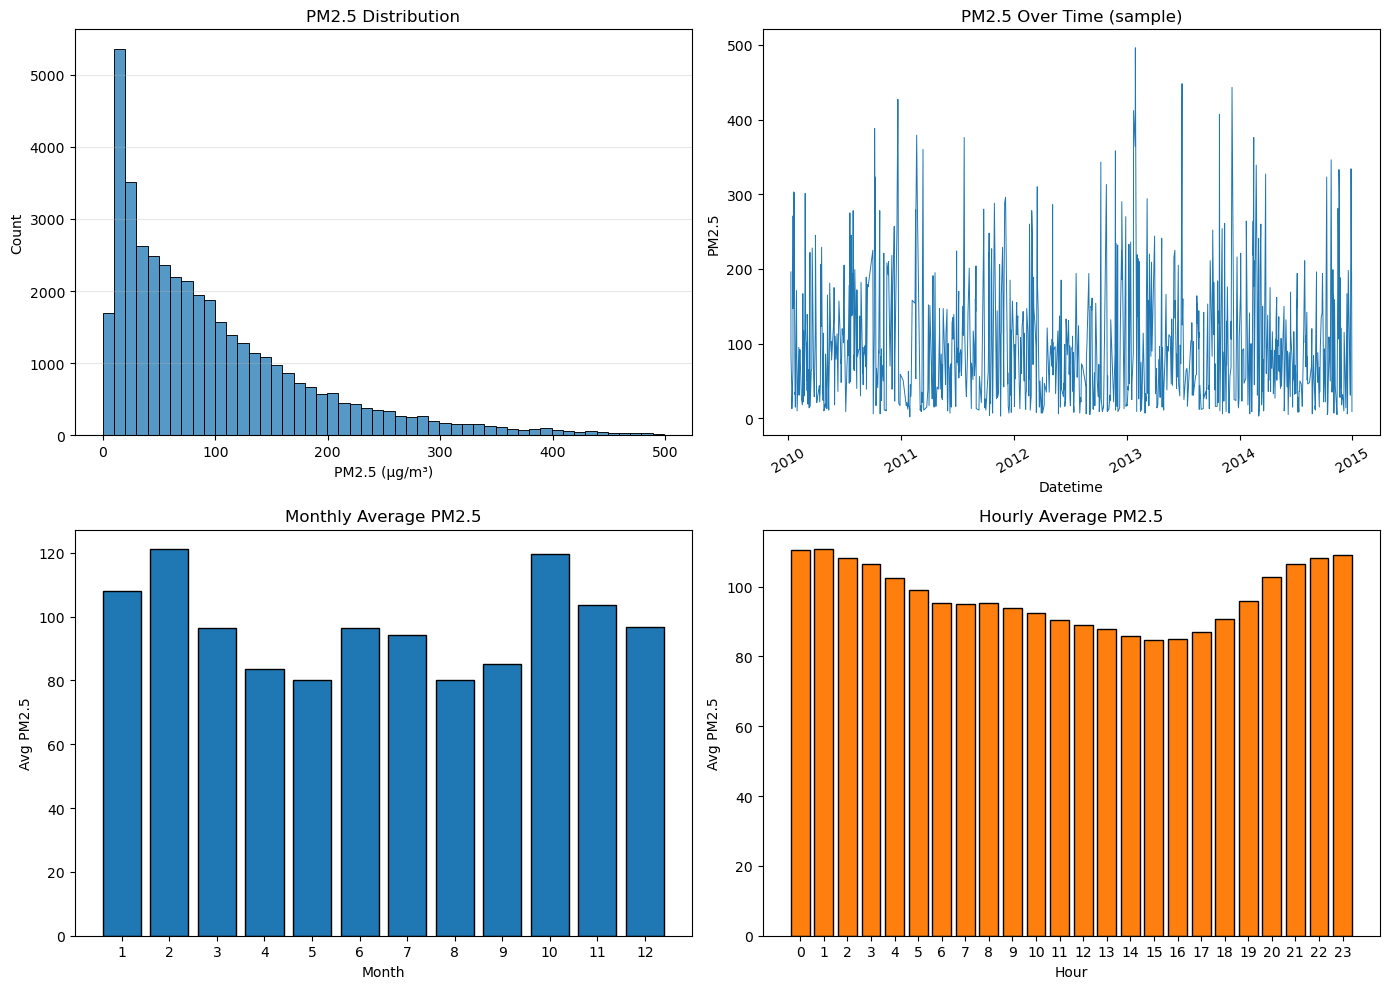


--- EDA TEMPORAL ---
Saved: beijing_eda_temporal.png


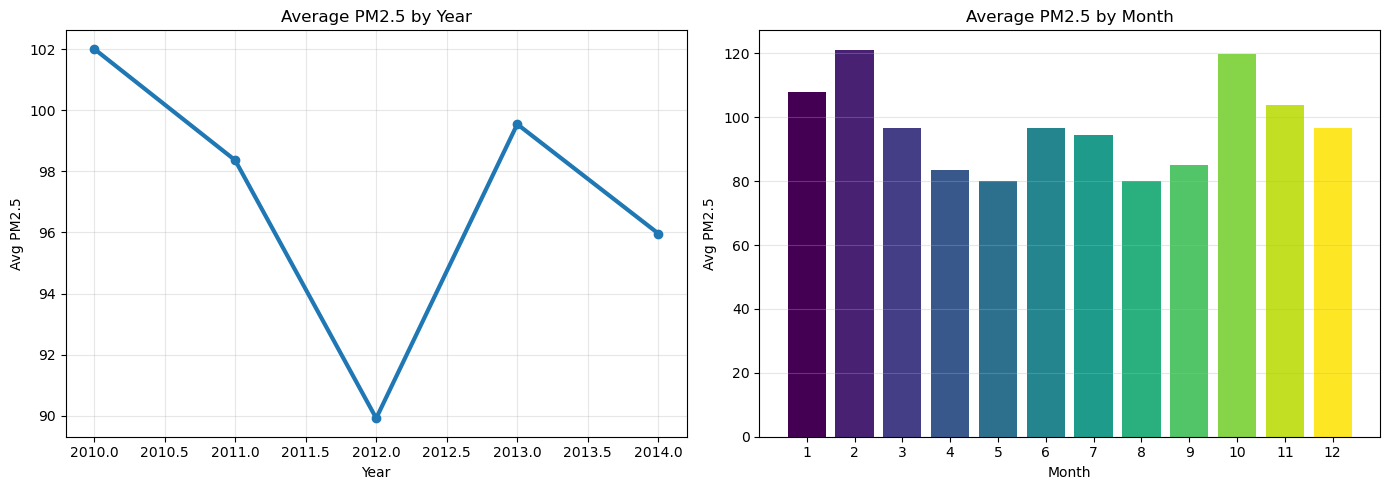


--- EDA WEATHER IMPACT ---
Saved: beijing_eda_weather.png


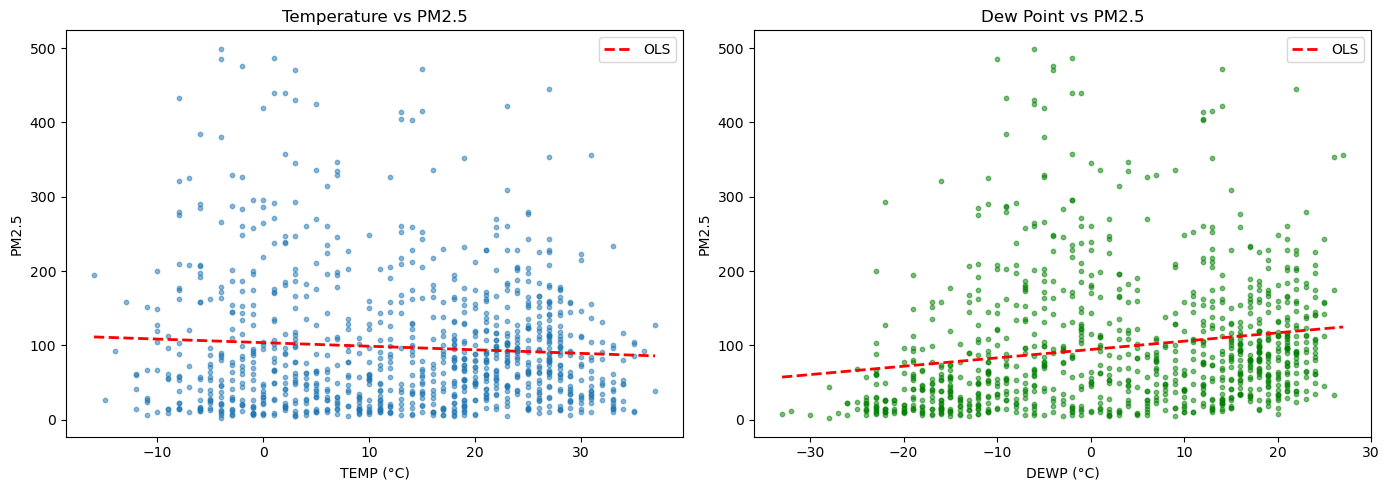


--- EDA CORRELATIONS ---
Saved: beijing_eda_correlation.png


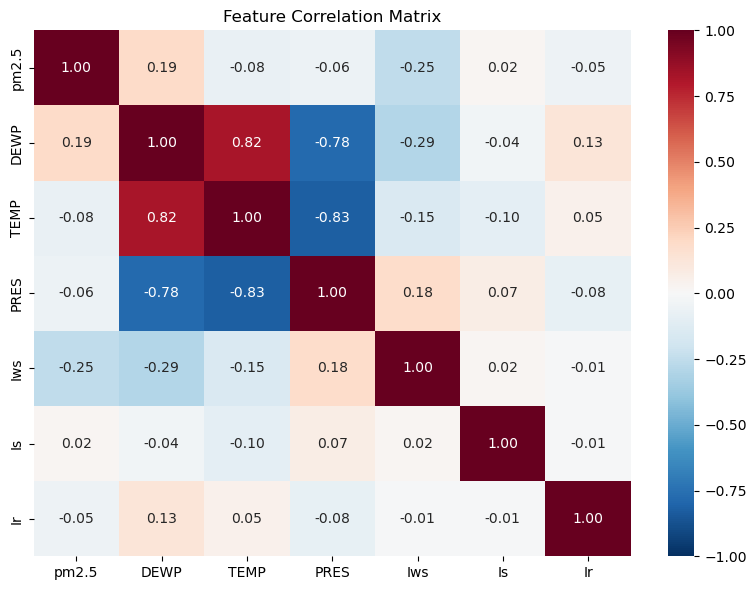


--- EDA EXTRA: Boxplots & Outlier Detection ---


C:\Users\hasan\AppData\Local\Temp\ipykernel_9788\81888255.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pm2.5', data=df, ax=axes[0], palette='viridis')
C:\Users\hasan\AppData\Local\Temp\ipykernel_9788\81888255.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='pm2.5', data=df, ax=axes[1], palette='cool')


Saved: beijing_eda_boxplots.png


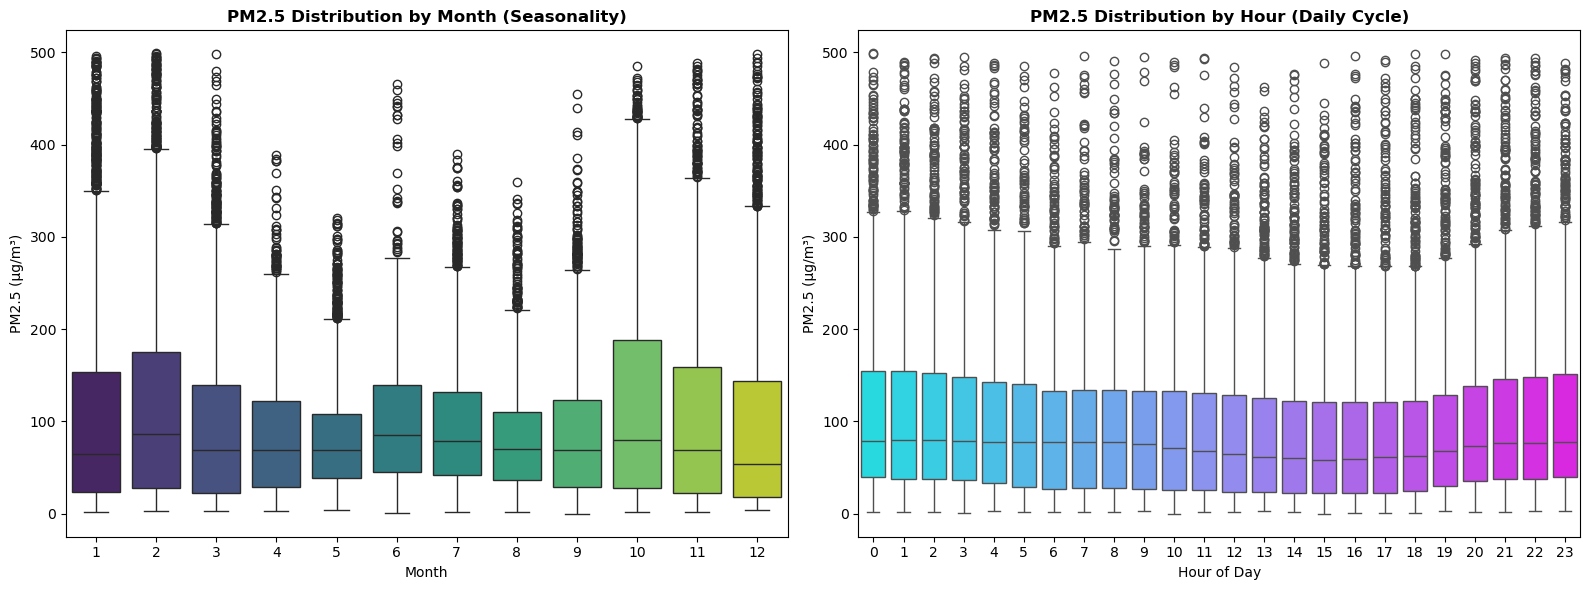

IQR method: Q1=29.00, Q3=136.00, IQR=107.00
Lower bound: -131.50, Upper bound: 296.50
Number of statistical outliers (1.5*IQR): 1709

FEATURE ENGINEERING
Dropped 24 rows containing NaNs created by lag features.

Features created:
- Time features: hour, day, month, dayofweek, season, hour_sin, hour_cos
- Meteorological: DEWP, TEMP, PRES, Iws, Is, Ir
- Rolling averages: 3h, 6h, 12h, 24h
- Lag features: 1h, 3h, 6h, 12h, 24h
- Wind direction (one-hot encoded)

Final dataset for modeling: 41607 rows, 31 columns

TRAIN/TEST SPLIT & NORMALIZATION
Visualizing Normalization Effect (TEMP feature)...


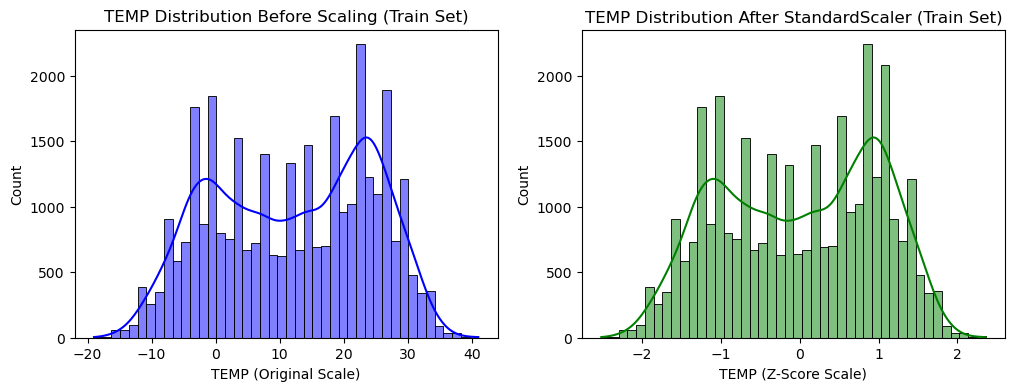


Features used: 26
Train set: 33285 samples (80%))
Test set: 8322 samples (20%)

Train PM2.5 - Mean: 97.39, Std: 87.53
Test PM2.5 - Mean: 95.97, Std: 89.83

LINEAR REGRESSION BASELINE

Train Results:
  MSE:  169.6405
  RMSE: 13.0246
  MAE:  7.6348
  R²:   0.9779

Test Results:
  MSE:  130.3470
  RMSE: 11.4170
  MAE:  6.7229
  R²:   0.9838

NEURAL NETWORK (ANN) WITH BACKPROPAGATION - SIGMOID

Architecture: 26 → 32 → 16 → 1
Learning rate: 0.001 (FIXED)
Training for 200 epochs using gradient descent with clipping...

Epoch 20/200 - Train Loss: 17046.2393, Test Loss: 17174.3742
Epoch 40/200 - Train Loss: 16948.8386, Test Loss: 17078.4456
Epoch 60/200 - Train Loss: 16858.1342, Test Loss: 16989.4379
Epoch 80/200 - Train Loss: 16775.1776, Test Loss: 16908.2318
Epoch 100/200 - Train Loss: 16699.9486, Test Loss: 16834.6415
Epoch 120/200 - Train Loss: 16631.8076, Test Loss: 16767.9500
Epoch 140/200 - Train Loss: 16569.3383, Test Loss: 16706.7141
Epoch 160/200 - Train Loss: 16511.1300, Test Loss:

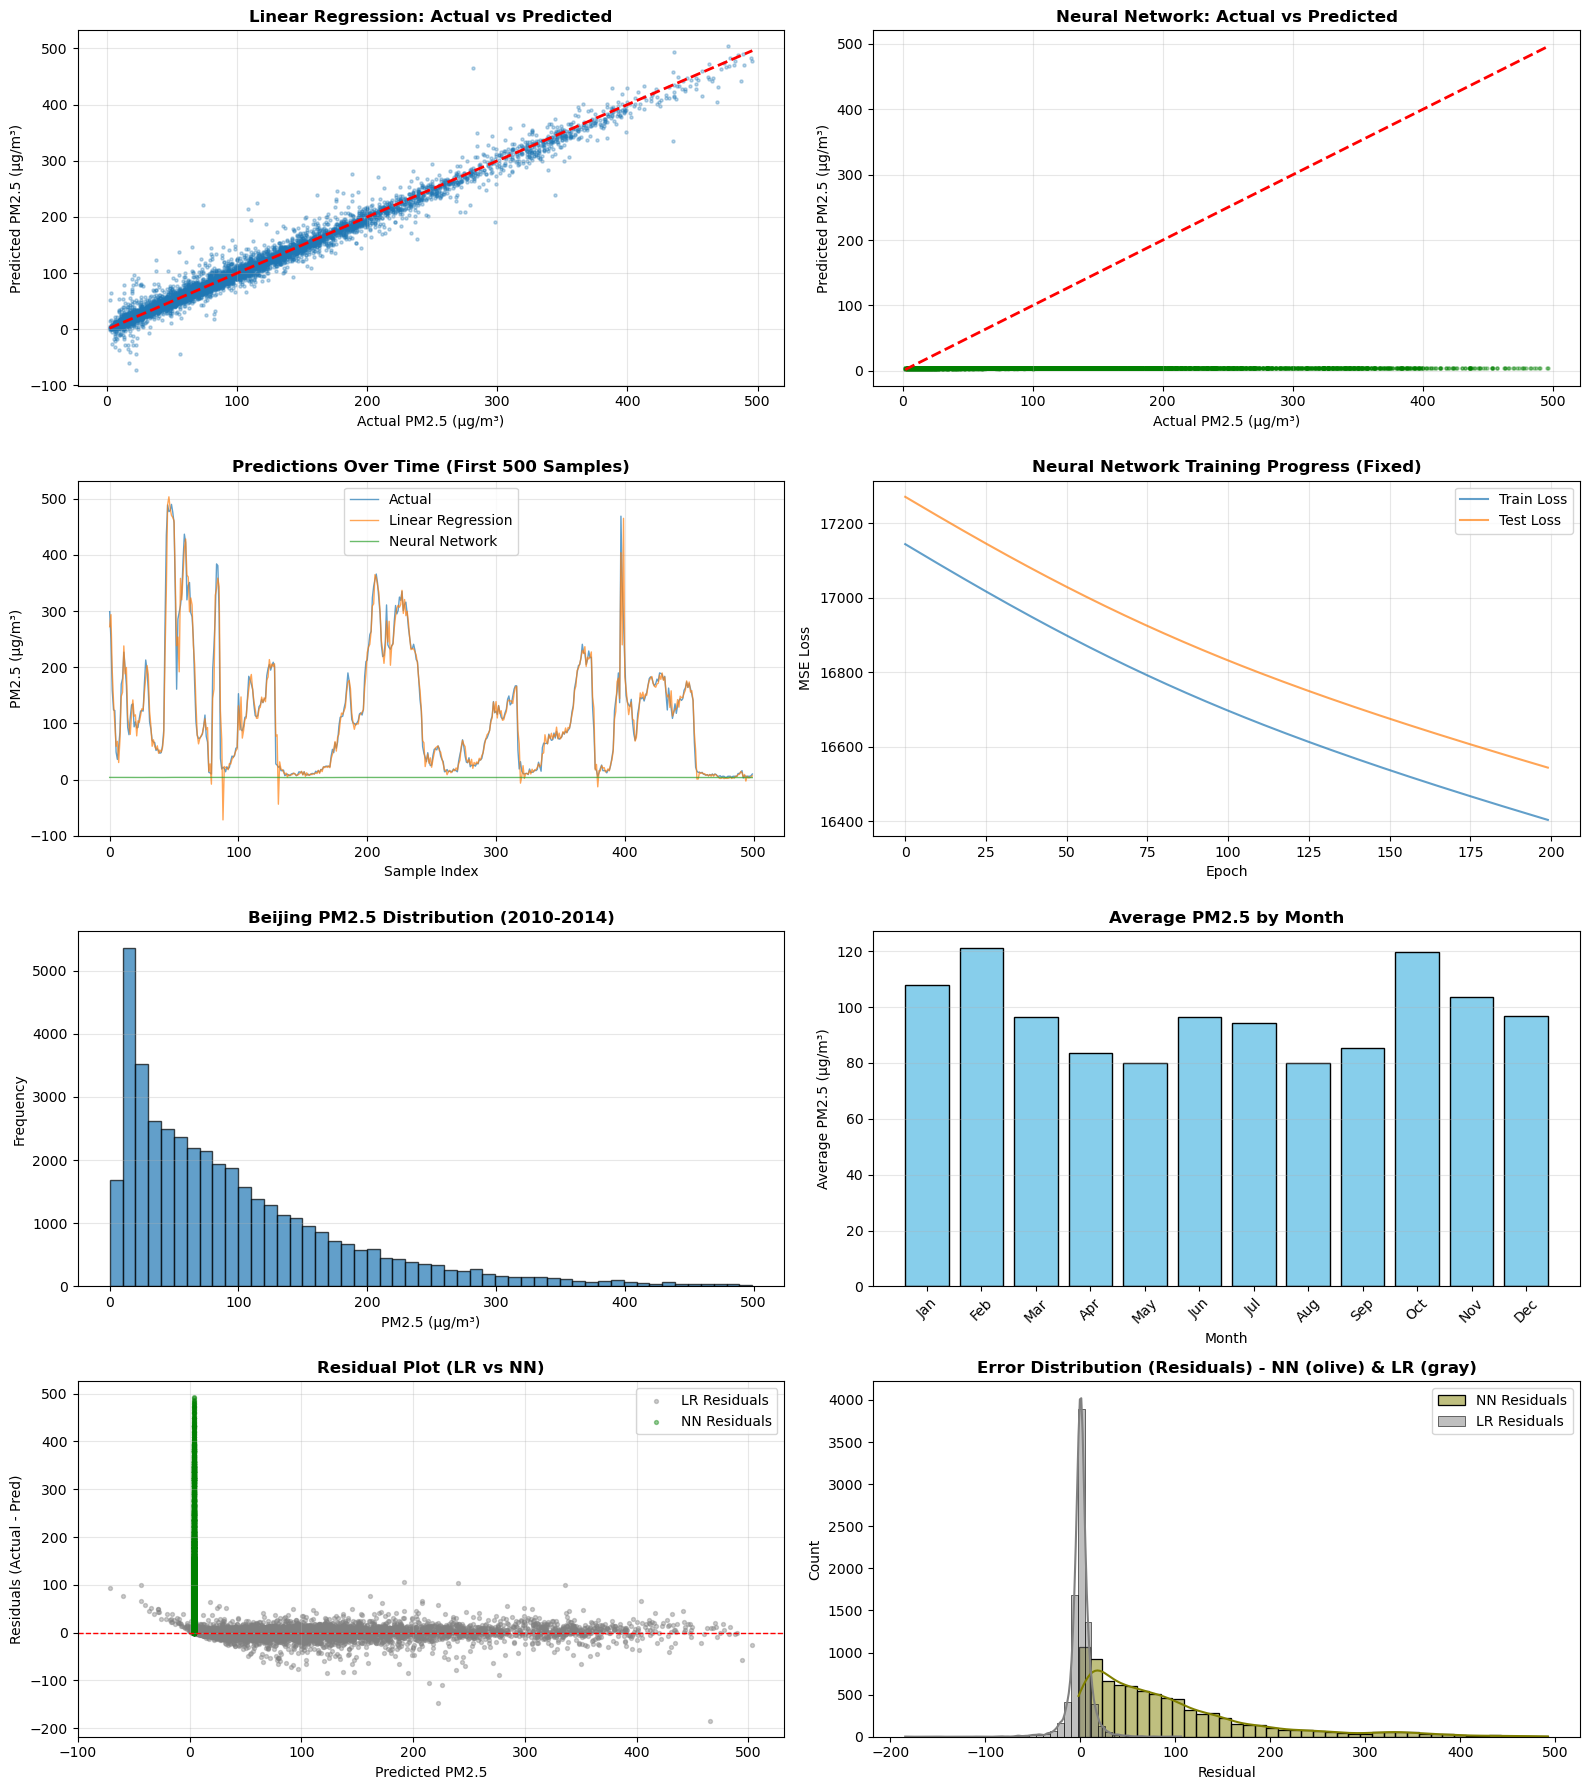

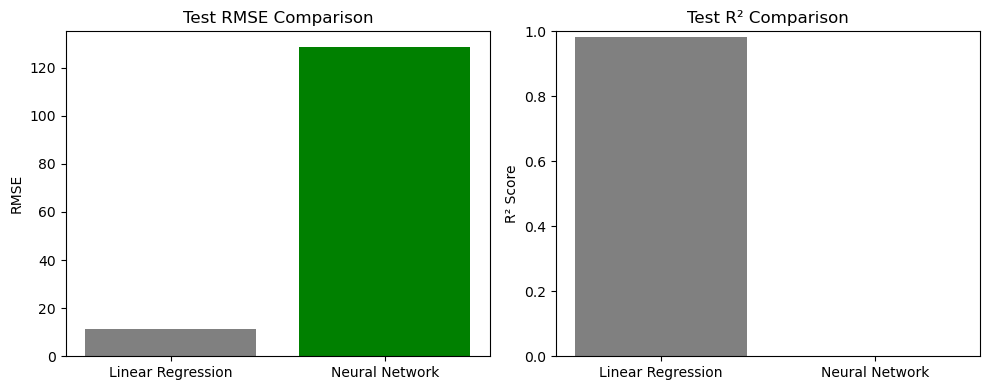


SUMMARY

Linear Regression Test RMSE: 11.4170
Neural Network Test RMSE:    128.6220

Linear Regression Test R²:   0.9838
Neural Network Test R²:      -1.0503


In [10]:

if __name__ == "__main__":
    # Ensure you have 'PRSA_data_2010.1.1-2014.12.31.csv' in your directory
    file_path = 'PRSA_data_2010.1.1-2014.12.31.csv'

    print("="*60)
    print("BEIJING PM2.5 AIR QUALITY PREDICTION")
    print("Using Linear Regression & Neural Network (Backpropagation)")
    print("="*60)

    try:
        # 1. Load
        df = load_beijing_data(file_path)

        # 2. Preprocess
        df = preprocess_beijing_data(df)

        # 3. Perform EDA (NEW STEP)
        perform_eda(df)

        # 4. Feature Engineering
        df = create_beijing_features(df)

        # 5. Split & Normalize
        X_train, X_test, y_train, y_test, scaler, feature_cols = prepare_train_test_beijing(df)

        # 6. Linear Regression
        y_pred_lr, lr_model = linear_regression_baseline(X_train, X_test, y_train, y_test)

        # 7. Neural Network (SIGMOID)
        y_pred_nn, nn_model, train_losses, test_losses = train_neural_network(
            X_train, X_test, y_train, y_test
        )

        # 8. Visualize results (includes residuals, error distribution, model comparison)
        plot_results(y_test, y_pred_lr, y_pred_nn, train_losses, test_losses, df)

        # Final Summary
        print("\n" + "="*50)
        print("SUMMARY")
        print("="*50)
        print(f"\nLinear Regression Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
        print(f"Neural Network Test RMSE:    {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")
        print(f"\nLinear Regression Test R²:   {r2_score(y_test, y_pred_lr):.4f}")
        print(f"Neural Network Test R²:      {r2_score(y_test, y_pred_nn):.4f}")


    except FileNotFoundError:
        print(f"\nError: File '{file_path}' not found.")
        print("\nPlease download the Beijing PM2.5 dataset:")
        print("   1. Go to: https://www.kaggle.com/datasets/djhavera/beijing-pm25-data-data-set")
        print("   2. Or: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data")
        print("   3. Download 'PRSA_data_2010.1.1-2014.12.31.csv'")
        print("   4. Place it in the same directory as this script")
        print("\n   Or update the 'file_path' variable with your actual file location")
